In [1]:
import scanpy as sc
#import gseapy as gs
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr, wilcoxon, mannwhitneyu

import pandas as pd

# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

sns.set_style('white')
sns.set_style('ticks', {'font.family': 'FreeSans'})

# Scanpy settings
sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

celltype = 'Monocyte'
master_dir = '../'

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 95361 × 1387
    obs: 'patient', 'ICU_status', 'IL6i_between_draws', 'no_IL6i', 'WHO_scale', 'Blood_draw_time', 'Sex', 'Age_at_baseline', 'Days_since_onset_of_symptoms', 'leiden', 'leiden_all', 'louvain', 'Days_since_onset_float', 'umap_density_ICU_status'
    uns: 'ICU_status_colors', 'leiden_all_colors', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_ICU_status_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
# Also read in the flow data summary
flow = pd.read_excel(master_dir + 'data/flow/data for Jihoon and Yapeng_updated.xlsx', 
                     sheet_name='monocyte HK2')
flow['Unnamed: 0'] = flow['Unnamed: 0'].str.replace('INCOV', '').str.lstrip('0')
flow.head(10)

Unnamed: 0  \
0       20-1   
1       22-2   
2       31-2   
3       32-2   
4       33-2   
5       34-2   
6       69-2   
7       79-2   
8       87-1   
9       88-1   

   HK2 fluorescence values of non-classical monocytes defined by HLA-DR and CD14  \
0                                             4025.5                               
1                                             7889.5                               
2                                             6939.6                               
3                                             5247.9                               
4                                             4572.1                               
5                                             4703.3                               
6                                             4703.8                               
7                                             4976.5                               
8                                             6704.7                               
9                                             4888.0                               

   HK2 fluorescence values of S100A9low classical monocytes  \
0                                           10661.50          
1                                            8766.30          
2                                            6516.00          
3                                            8433.00          
4                                            8906.90          
5                                            8217.00          
6                                            7175.00          
7                                            8407.13          
8                                            7305.00          
9                                            7305.10          

   HK2 fluorescence values of S100A9high classical monocytes  
0                                           12056.00          
1                                           11993.80          
2                                           13028.40          
3                                           11738.20          
4                                           10290.98          
5                                           10256.90          
6                                           10630.00          
7                                           10489.20          
8                                           10778.50          
9                                           11105.30

In [4]:
adata_focused = adata_metab[adata_metab.obs['patient'].isin(flow['Unnamed: 0'])]
adata_focused = adata_focused[adata_focused.obs['louvain']=='2']
adata_focused.X[:, np.where(adata_focused.var_names=='HK2')].flatten()

ArrayView([0.21710531, 0.3426329 , 0.30263895, ..., 0.07586741,
           0.17502132, 0.1654737 ], dtype=float32)

Text(0.5, 0, 'Metabolic cluster')

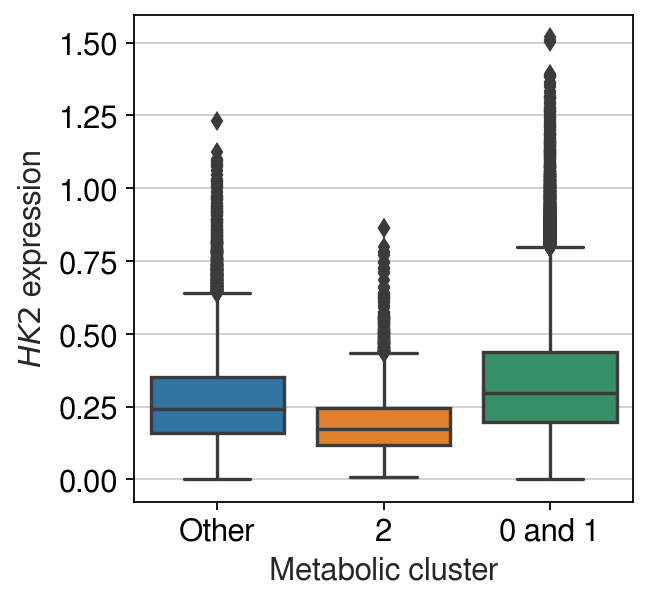

In [5]:
a = pd.DataFrame(adata_metab[~adata_metab.obs['louvain'].isin(['0', '1', '2'])].X[:, 
                                                np.where(adata_focused.var_names=='HK2')].flatten())
a['louvain'] = 'Other'

b = pd.DataFrame(adata_metab[adata_metab.obs['louvain']=='2'].X[:, 
                                                np.where(adata_focused.var_names=='HK2')].flatten())
b['louvain'] = '2'

c = pd.DataFrame(adata_metab[adata_metab.obs['louvain'].isin(['0', '1'])].X[:, 
                                                np.where(adata_focused.var_names=='HK2')].flatten())
c['louvain'] = '0 and 1'

a = pd.concat([a, b, c])

sns.boxplot(data=a, x='louvain', y=0)
plt.ylabel(r'$\itHK2$ expression')
plt.xlabel('Metabolic cluster')
#plt.savefig(master_dir + 'output/flow/monocyte-metab-cluster-0-1-2_HK2-comparison.pdf')

In [6]:
mannwhitneyu(a[a['louvain']=='Other'][0], a[a['louvain']=='0 or 1'][0])

/home/jwlee/.local/lib/python3.8/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [7]:
mannwhitneyu(a[a['louvain']=='Other'][0], a[a['louvain']=='2'][0])

MannwhitneyuResult(statistic=38791874.5, pvalue=1.393242322419404e-263)

In [8]:
mannwhitneyu(a[a['louvain']=='2'][0], a[a['louvain']=='0 or 1'][0])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

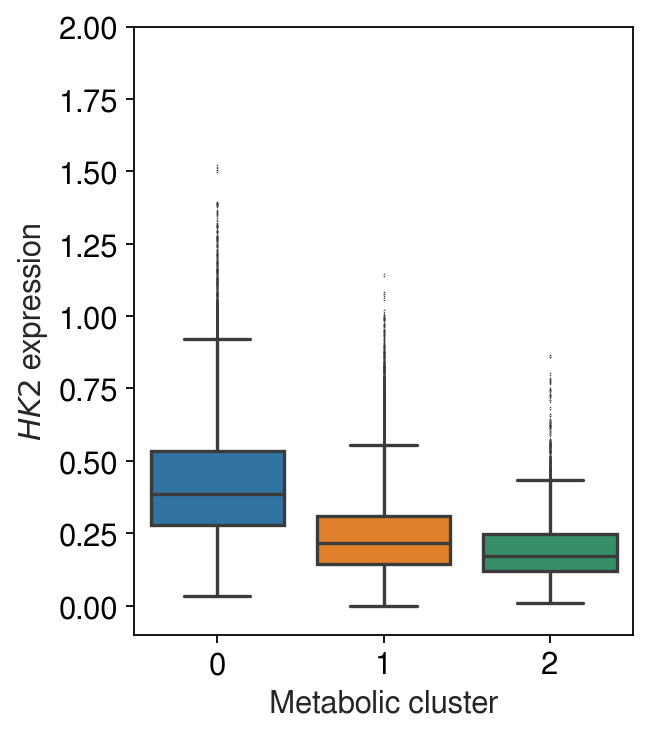

In [9]:
a = pd.DataFrame(adata_metab[~adata_metab.obs['louvain'].isin(['0', '1', '2'])].X[:, 
                                                np.where(adata_focused.var_names=='HK2')].flatten())
a['louvain'] = 'Other'

b = pd.DataFrame(adata_metab[adata_metab.obs['louvain']=='2'].X[:, 
                                                np.where(adata_focused.var_names=='HK2')].flatten())
b['louvain'] = '2'

c = pd.DataFrame(adata_metab[adata_metab.obs['louvain']=='0'].X[:, 
                                                np.where(adata_focused.var_names=='HK2')].flatten())
c['louvain'] = '0'

d = pd.DataFrame(adata_metab[adata_metab.obs['louvain']=='1'].X[:, 
                                                np.where(adata_focused.var_names=='HK2')].flatten())
d['louvain'] = '1'

a = pd.concat([c, d, b]) #Disregard the "other"

plt.figure(figsize=[4, 5])
sns.boxplot(data=a, x='louvain', y=0, fliersize=0.01)
plt.ylabel(r'$\itHK2$ expression')
plt.xlabel('Metabolic cluster')
plt.ylim([-0.1, 2])
plt.grid(False)
#plt.savefig(master_dir + 'output/flow/monocyte-metab-cluster-0-1-2_HK2-comparison-alt.pdf')

In [10]:
mannwhitneyu(a[a['louvain']=='0'][0], a[a['louvain']=='1'][0])

MannwhitneyuResult(statistic=245553115.5, pvalue=0.0)

In [11]:
mannwhitneyu(a[a['louvain']=='1'][0], a[a['louvain']=='2'][0])

MannwhitneyuResult(statistic=73751449.0, pvalue=2.522045746553398e-137)

In [12]:
mannwhitneyu(a[a['louvain']=='0'][0], a[a['louvain']=='2'][0])

MannwhitneyuResult(statistic=25890370.5, pvalue=0.0)

In [13]:
# Replotting flow data
flow.head()

Unnamed: 0  \
0       20-1   
1       22-2   
2       31-2   
3       32-2   
4       33-2   

   HK2 fluorescence values of non-classical monocytes defined by HLA-DR and CD14  \
0                                             4025.5                               
1                                             7889.5                               
2                                             6939.6                               
3                                             5247.9                               
4                                             4572.1                               

   HK2 fluorescence values of S100A9low classical monocytes  \
0                                            10661.5          
1                                             8766.3          
2                                             6516.0          
3                                             8433.0          
4                                             8906.9          

   HK2 fluorescence values of S100A9high classical monocytes  
0                                           12056.00          
1                                           11993.80          
2                                           13028.40          
3                                           11738.20          
4                                           10290.98

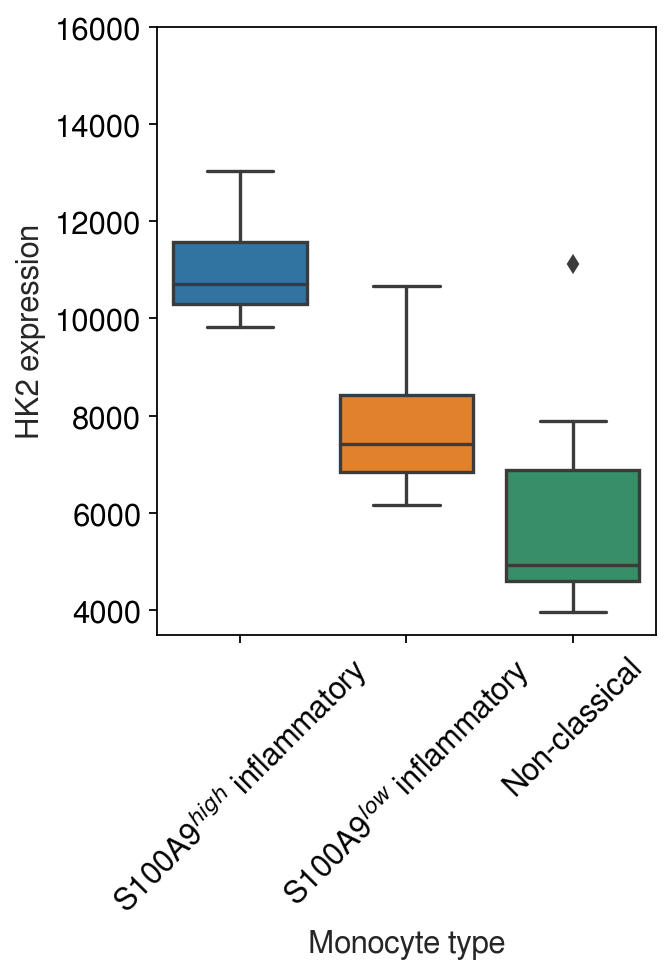

In [14]:
a = flow.iloc[:, [3, 2, 1]].values.flatten()
plt.figure(figsize=[4, 5])
fig = sns.boxplot(x=['S100hi classical', 'S100lo classical', 'Non-classical'] * len(flow),
            y=a)
plt.ylabel('HK2 expression')
plt.ylim([3500, 16000])
fig.set_xticklabels(['S100A9$^{high}$ inflammatory', 'S100A9$^{low}$ inflammatory', 'Non-classical'],
                   rotation=45)
plt.xlabel('Monocyte type')

plt.grid(False)
#plt.savefig(master_dir + 'output/flow/monocyte-flow-cluster_HK2-comparison.pdf')

In [15]:
mannwhitneyu(flow.iloc[:, 1], flow.iloc[:, 2])

MannwhitneyuResult(statistic=34.0, pvalue=0.0017632433253079232)

In [16]:
mannwhitneyu(flow.iloc[:, 2], flow.iloc[:, 3])

MannwhitneyuResult(statistic=7.0, pvalue=1.6033691434369572e-05)

In [17]:
mannwhitneyu(flow.iloc[:, 1], flow.iloc[:, 3])

MannwhitneyuResult(statistic=10.0, pvalue=2.9046990384359175e-05)

### Correlations between flow data and 10X data

Need to use the full current 10X dataset to account for new patients

In [18]:
adata_full = sc.read_h5ad(master_dir + 'data/PBMC_processed/flow_comparisons/monocytes_50_gex_imputed.h5ad')
adata_full

AnnData object with n_obs × n_vars = 124343 × 25711
    obs: 'batch_info', 'batch', 'subbatch', 'sample', 'patient', 'status', 'cell_groups', 'B7-H4', 'CD10', 'CD101_BB27', 'CD103_Integrin-AE', 'CD106', 'CD107A_LAMP-1', 'CD112_NECTIN-2', 'CD117_c-Kit', 'CD11A', 'CD11B', 'CD11C', 'CD122_IL-2RB', 'CD123', 'CD124_IL-4RA', 'CD127_IL-7RA', 'CD133', 'CD137L_4-1BB_Ligand', 'CD137_4-1BB', 'CD138_Syndecan-1', 'CD14-1', 'CD141_Thrombomodulin', 'CD144_VE-Cadherin', 'CD146', 'CD150_SLAM', 'CD152_CTLA-4', 'CD154', 'CD155_PVR', 'CD158B_KIR2DL2-L3_NKAT3', 'CD158E1_KIR3DL1_NKB1', 'CD158F_KIR2DL5', 'CD158_KIR2DL1-S1-S3-S5', 'CD15_SSEA-1', 'CD16', 'CD161', 'CD163-1', 'CD169_Sialoadhesin_Siglec-1', 'CD178_FAS-L', 'CD18', 'CD183_CXCR3', 'CD184_CXCR4', 'CD185_CXCR5', 'CD19-1', 'CD193_CCR3', 'CD194_CCR4', 'CD195_CCR5', 'CD196_CCR6', 'CD197_CCR7', 'CD1A-1', 'CD1C-1', 'CD1D-1', 'CD2-1', 'CD20', 'CD204', 'CD206_MMR', 'CD207-1', 'CD209_DC-SIGN', 'CD21', 'CD22-1', 'CD223_LAG-3', 'CD224', 'CD226_DNAM-1', 'CD23', 

In [19]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)

metab_pathway_list = metab_genes.index

# Get a flat array of metabolism-related genes
metab_gene_list = np.array(metab_genes.iloc[:, 1:]).flatten().astype(str)
metab_gene_list = metab_gene_list[metab_gene_list != 'nan']

# Make a new data object with only the metabolic genes from the KEGG pathways
metab_gene_list_overlap = list(set(metab_gene_list).intersection(set(adata_full.var_names)))
adata_metab = adata_full[:, metab_gene_list_overlap]

# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata_full.var_names)))

In [34]:
len(metab_gene_list_overlap)

1481

In [20]:
sc.tl.pca(adata_metab, svd_solver='arpack')
sc.pp.neighbors(adata_metab)
sc.tl.umap(adata_metab)
sc.tl.louvain(adata_metab, resolution=0.1)

computing PCA
    with n_comps=50
    finished (0:00:38)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:43)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:58)


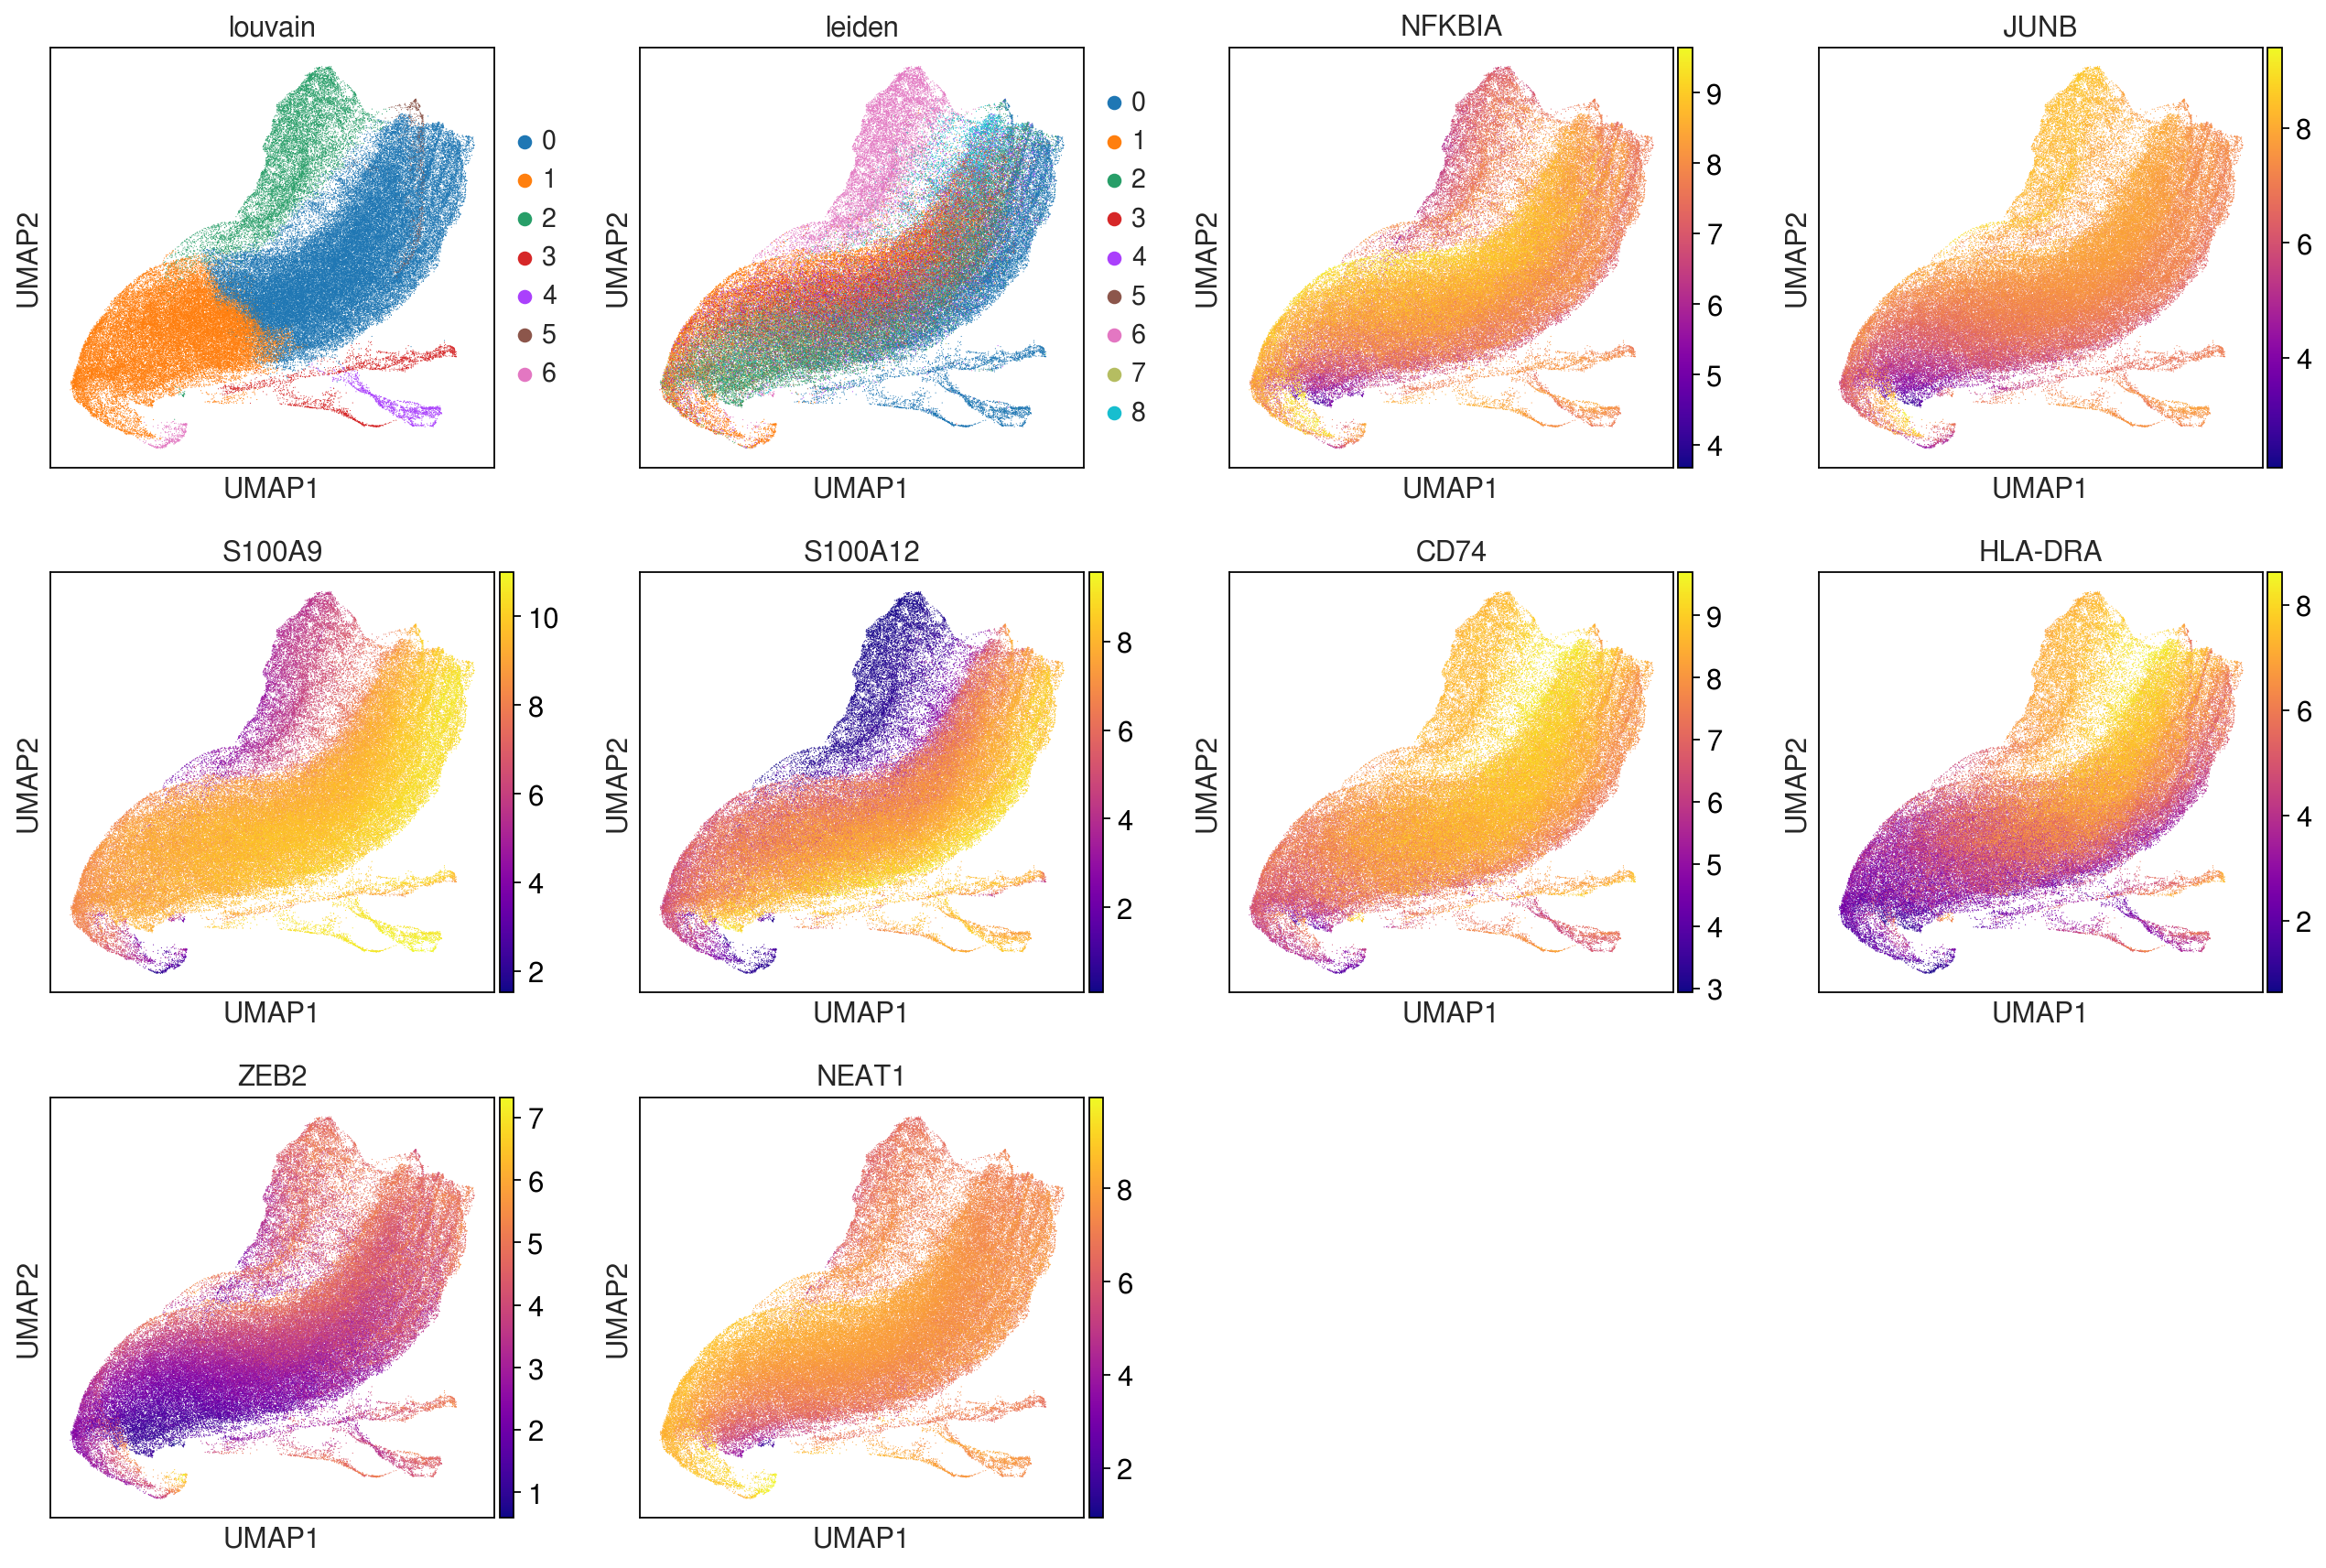

In [21]:
adata_metab_all_genes = adata_full.copy()
adata_metab_all_genes.obs = adata_metab.obs.copy()
adata_metab_all_genes.uns = adata_metab.uns.copy()
adata_metab_all_genes.obsm = adata_metab.obsm.copy()
fig = sc.pl.umap(adata_metab_all_genes, color=['louvain', 'leiden', 'NFKBIA', 'JUNB', 'S100A9', 
                                               'S100A12', 'CD74', 'HLA-DRA', 'ZEB2', 
         'NEAT1'], cmap='plasma', use_raw=False)

In [22]:
sc.tl.umap(adata_metab, min_dist=1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:59)


In [23]:
sc.tl.louvain(adata_metab, resolution=0.25)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:01:22)


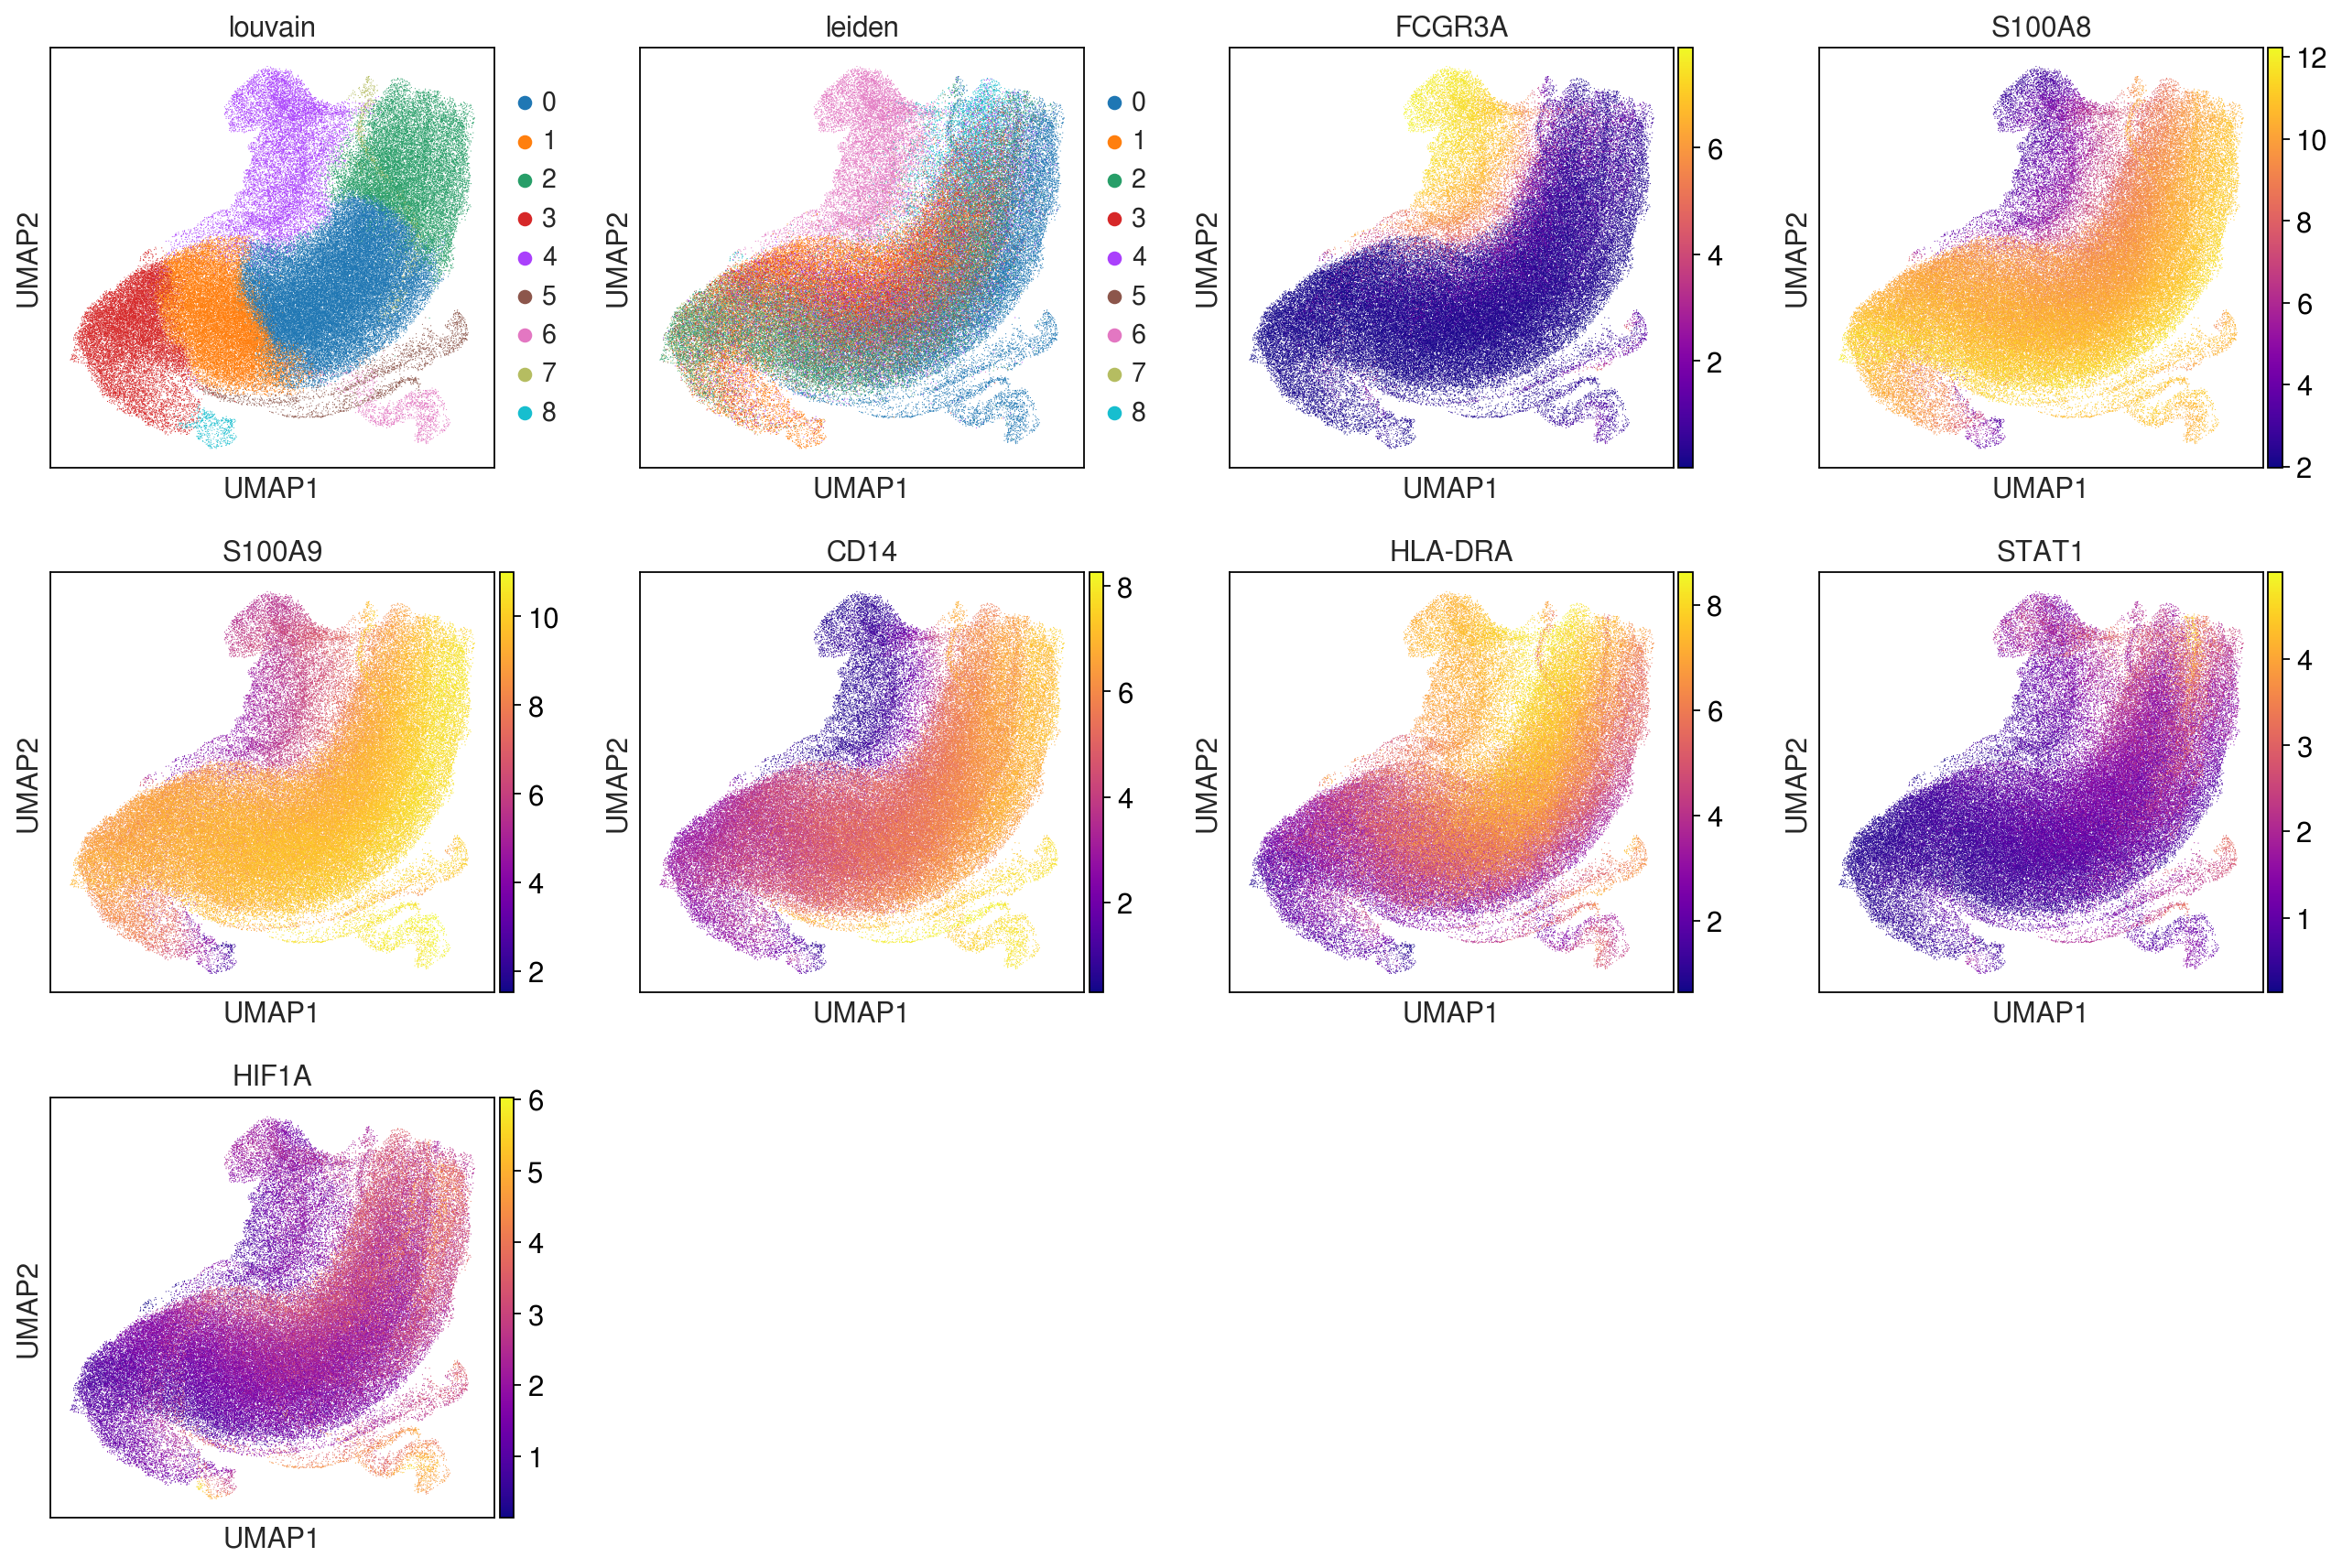

In [24]:
adata_metab_all_genes = adata_full.copy()
adata_metab_all_genes.obs = adata_metab.obs.copy()
adata_metab_all_genes.uns = adata_metab.uns.copy()
adata_metab_all_genes.obsm = adata_metab.obsm.copy()
fig = sc.pl.umap(adata_metab_all_genes, color=['louvain', 'leiden', 'FCGR3A', 'S100A8', 'S100A9', 
                                               'CD14', 'HLA-DRA', 'STAT1', 'HIF1A'], 
                 cmap='plasma', use_raw=False)

In [29]:
adata_metab.write(master_dir + 'output/flow/Monocyte-new_10X-metab.h5ad')

In [36]:
adata_metab

AnnData object with n_obs × n_vars = 124343 × 1481
    obs: 'batch_info', 'batch', 'subbatch', 'sample', 'patient', 'status', 'cell_groups', 'B7-H4', 'CD10', 'CD101_BB27', 'CD103_Integrin-AE', 'CD106', 'CD107A_LAMP-1', 'CD112_NECTIN-2', 'CD117_c-Kit', 'CD11A', 'CD11B', 'CD11C', 'CD122_IL-2RB', 'CD123', 'CD124_IL-4RA', 'CD127_IL-7RA', 'CD133', 'CD137L_4-1BB_Ligand', 'CD137_4-1BB', 'CD138_Syndecan-1', 'CD14-1', 'CD141_Thrombomodulin', 'CD144_VE-Cadherin', 'CD146', 'CD150_SLAM', 'CD152_CTLA-4', 'CD154', 'CD155_PVR', 'CD158B_KIR2DL2-L3_NKAT3', 'CD158E1_KIR3DL1_NKB1', 'CD158F_KIR2DL5', 'CD158_KIR2DL1-S1-S3-S5', 'CD15_SSEA-1', 'CD16', 'CD161', 'CD163-1', 'CD169_Sialoadhesin_Siglec-1', 'CD178_FAS-L', 'CD18', 'CD183_CXCR3', 'CD184_CXCR4', 'CD185_CXCR5', 'CD19-1', 'CD193_CCR3', 'CD194_CCR4', 'CD195_CCR5', 'CD196_CCR6', 'CD197_CCR7', 'CD1A-1', 'CD1C-1', 'CD1D-1', 'CD2-1', 'CD20', 'CD204', 'CD206_MMR', 'CD207-1', 'CD209_DC-SIGN', 'CD21', 'CD22-1', 'CD223_LAG-3', 'CD224', 'CD226_DNAM-1', 'CD23', '

In [ ]:
# Non-classical: CD14low CD16 (FCGR3A)+ HLA-DRhi --> metabolic cluster 4
# Clasical: CD14+ CD16- HLA-DRmid --> metabolic cluster 0, 1, 7?
# Among the classical, metabolic cluster 0 is S100A9mid while 1 and 7 are S100A9hi to correlate with flow
adata_metab.obs['HK2 gex'] = np.expm1(adata_metab.X[:, np.where(adata_metab.var_names=='HK2')].flatten())
adata_metab.obs['S100A9 gex'] = np.expm1(adata_metab_all_genes.X[:, np.where(adata_metab_all_genes.var_names=='S100A9')].flatten())
#adata_metab.obs['HK2 gex'] = adata_metab.X[:, np.where(adata_metab.var_names=='HK2')].flatten()

gex2 = adata_metab.obs[adata_metab.obs['louvain']=='4']#.dropna(subset=['HK2 gex'])
gex2 = gex2.groupby('sample')['HK2 gex'].mean().dropna(0).rename('Nonclassical HK2')

gex0 = adata_metab.obs[adata_metab.obs['louvain']=='0']#.dropna(subset=['HK2 gex'])
gex0 = gex0.groupby('sample')['HK2 gex'].mean().dropna(0).rename('S100A9lo classical HK2')

gex1_7 = adata_metab.obs[adata_metab.obs['louvain']=='2']#.dropna(subset=['HK2 gex'])
gex1_7 = gex1_7.groupby('sample')['HK2 gex'].mean().dropna(0).rename('S100A9hi classical HK2')

flow['Unnamed: 0']

flow_vs_gex = flow.set_index('Unnamed: 0')
i = 0
for gex in [gex2, gex0, gex1_7]:
    i += 1
    flow_vs_gex = pd.merge(flow_vs_gex, gex, 
                           left_index=True, right_index=True, how='left')
    #flow_vs_gex.columns[-1] = 'HK2 ' + str(i)

# Drop outliers
flow_vs_gex = flow_vs_gex.dropna()

flow_cols = {'Nonclassical HK2': 'HK2 fluorescence values of non-classical monocytes defined by HLA-DR and CD14',
            'S100A9lo classical HK2': 'HK2 fluorescence values of S100A9low classical monocytes',
            'S100A9hi classical HK2': 'HK2 fluorescence values of S100A9high classical monocytes'}

<AxesSubplot:xlabel='louvain', ylabel='S100A9 gex'>

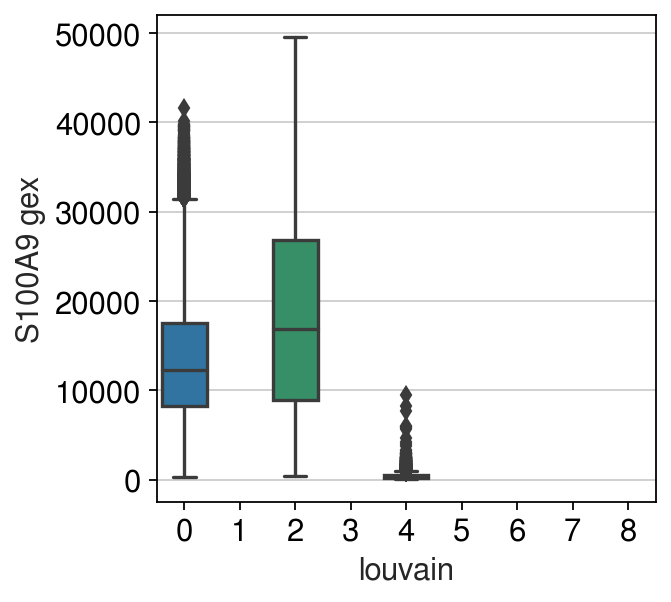

In [40]:
temp = adata_metab.obs[adata_metab.obs['louvain'].isin(['4', '2', '0'])]
sns.boxplot(data=temp, x='louvain', y='S100A9 gex')

/home/jwlee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jwlee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Pearson: (0.8609791727820372, 1.628770752858891e-11)


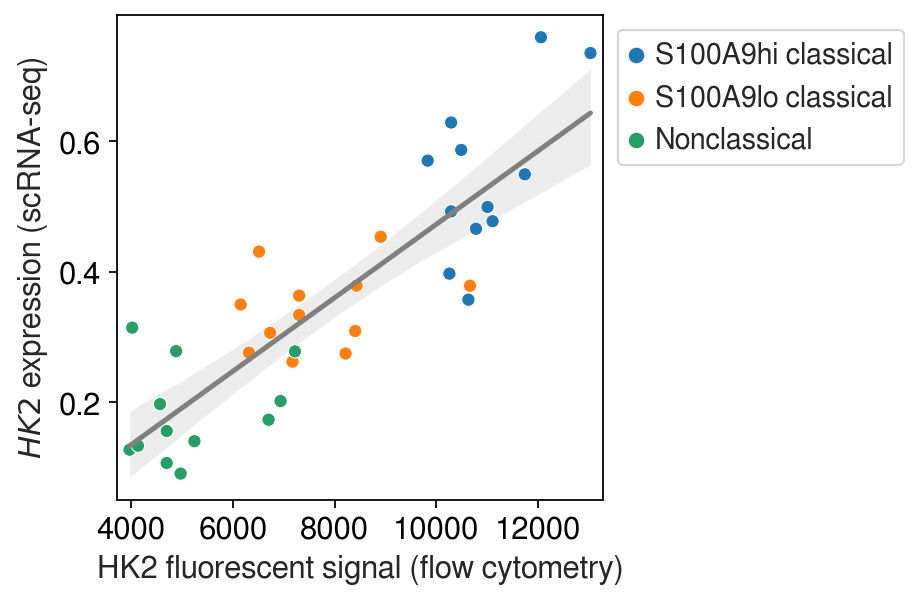

In [27]:
temp1 = flow_vs_gex[['HK2 fluorescence values of non-classical monocytes defined by HLA-DR and CD14',
                   'Nonclassical HK2']]
temp1.columns = ['flow', '10X']
temp1.loc[:, 'type'] = 'Nonclassical'

temp2 = flow_vs_gex[['HK2 fluorescence values of S100A9low classical monocytes',
                   'S100A9lo classical HK2']]
temp2.columns = ['flow', '10X']
temp2.loc[:, 'type'] = 'S100A9lo classical'

temp3 = flow_vs_gex[['HK2 fluorescence values of S100A9high classical monocytes',
                   'S100A9hi classical HK2']]
temp3.columns = ['flow', '10X']
temp3.loc[:, 'type'] = 'S100A9hi classical'

flow_vs_gex_comb = pd.concat([temp3, temp2, temp1])

g = plt.figure(figsize=(6, 4))    

# 142-2 had invalid CD8 data, so will be discarded from this comparison plot as well
g = sns.regplot(data=flow_vs_gex_comb.drop('142-2'), x='flow', 
            y='10X', color='gray', scatter_kws={'s':0})
g = sns.scatterplot(data=flow_vs_gex_comb.drop('142-2'), x='flow', 
            y='10X', hue='type')
g.set_ylabel(r'$\itHK2$ expression (scRNA-seq)')
g.set_xlabel('HK2 fluorescent signal (flow cytometry)')
g.grid(False)
g.set_xlim(g.get_xlim()[0] - 250, g.get_xlim()[1] + 250)
print('Pearson: ' + str(pearsonr(flow_vs_gex_comb.drop('142-2')['flow'], 
                                 flow_vs_gex_comb.drop('142-2')['10X'])))
plt.legend( bbox_to_anchor=(1, 1) )

plt.tight_layout()
#plt.savefig(master_dir + 'output/flow/Monocyte-flow-vs-10X_HK2-all.pdf')